In [69]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, find_peaks_cwt

In [70]:
## Signal processing containers.
raw_signal = np.array([])
filtered = np.array([])
differentiated_signal = np.array([])
squared_signal = np.array([])
integrated_signal = np.array([])

## Fiducial mark.
fiducial_mark_idx = np.array([])
fiducial_mark_val_i = np.array([])
fiducial_mark_val_f = np.array([])

## Integrated signal detection and thresholding.
spk_i = 0.0 
npk_i = 0.0 
threshold_i_1 = 0.0
threshold_i_2 = 0.0 
qrs_peak_i = np.array([])
noise_peak_i = np.array([])

peak_vals_i = np.array([])
spk_i_vals = np.array([])
npk_i_vals = np.array([])
threshold_i_1_vals = np.array([])
threshold_i_2_vals = np.array([])

## Filtered signal detection and thresholding.
spk_f = 0.0 
npk_f = 0.0 
threshold_f_1 = 0.0
threshold_f_2 = 0.0 
qrs_peak_f = np.array([])
noise_peak_f = np.array([])

peak_vals_f = np.array([])
spk_f_vals = np.array([])
npk_f_vals = np.array([])
threshold_f_1_vals = np.array([])
threshold_f_2_vals = np.array([])

## Realtime log detection.
logged_beats = np.array([])

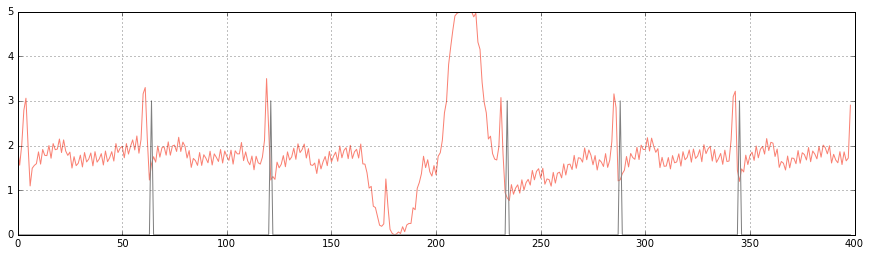

In [71]:
## Load and clean data.
with open("logs/s5/ecg/qrs_2016-01-29_14-09-03_333_datalog.txt") as f:
    content = f.readlines()
content = content[1:400]
raw_data = []
for line in content:
    log = line.rstrip().split(' ')
#     print log
    raw_signal = np.append(raw_signal, float(line.rstrip().split(' ')[2]))
    logged_beats = np.append(logged_beats, float(line.rstrip().split(' ')[3]))

plt.figure(figsize=(15,4))
plt.grid(True)
plt.plot(raw_signal, label="Original signal", color="salmon")
plt.plot(logged_beats * 3, label="Original signal", color="grey")

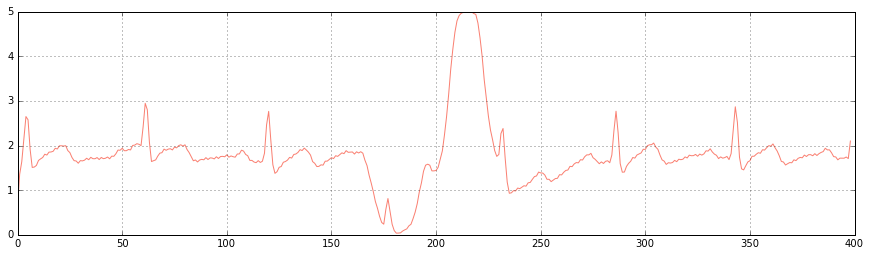

In [72]:
## Signal filtering methods.
def butter_bandpass_filter(data, lowcut, highcut, signal_freq, order):
    nyquist_freq = 0.5 * signal_freq
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, data)
    return y

## Signal filtering - pass band 0-12 Hz.
filtered_signal = butter_bandpass_filter(raw_signal, lowcut=0.0, highcut=12.0, signal_freq=84.0, order=1)
# filtered_signal = filtered_signal / max(filtered_signal)

plt.figure(figsize=(15,4))
plt.grid(True)
plt.plot(filtered_signal, label="Filtered signal", color="salmon")

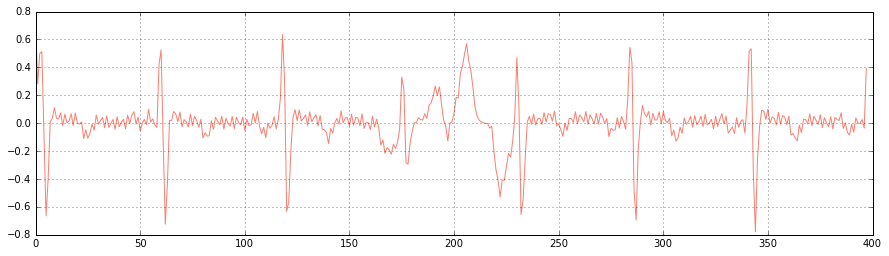

In [73]:
## Derivative original - provides QRS slope info.
differentiated_signal = np.diff(filtered_signal)
# differentiated_signal = differentiated_signal / max(differentiated_signal)

plt.figure(figsize=(15,4))
plt.grid(True)
plt.plot(differentiated_signal, label="Differentiated signal", color="salmon")

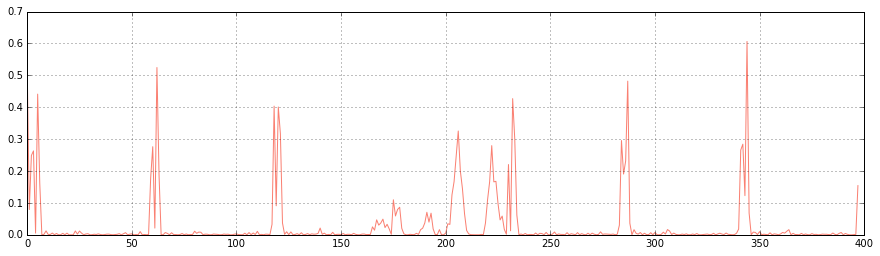

In [74]:
## Squaring.
squared_signal = np.power(differentiated_signal, 2)
# squared_signal = squared_signal / max(squared_signal)

plt.figure(figsize=(15,4))
plt.grid(True)
plt.plot(squared_signal, label="Squared signal", color="salmon")

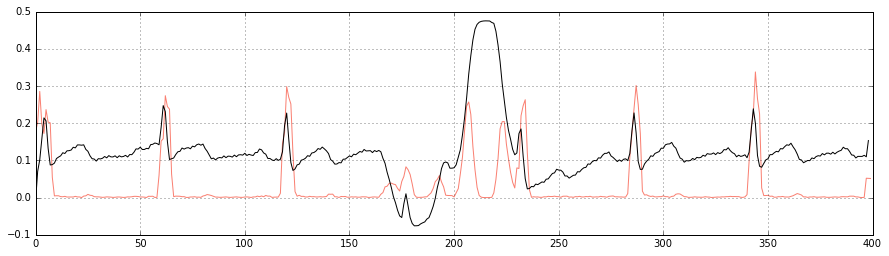

In [75]:
## Moving-window integration.
N = 3
integrated_signal = np.convolve(squared_signal, np.ones((N,))/N)
# integrated_signal = integrated_signal / max(integrated_signal) 

plt.figure(figsize=(15,4))
plt.grid(True)
plt.plot(integrated_signal, label="Integrated signal", color="salmon")
plt.plot((filtered_signal / 9.0) - 0.08, label="Integrated signal", color="black")

(0.0, 399.0, 0.0, 0.33781398821188763)

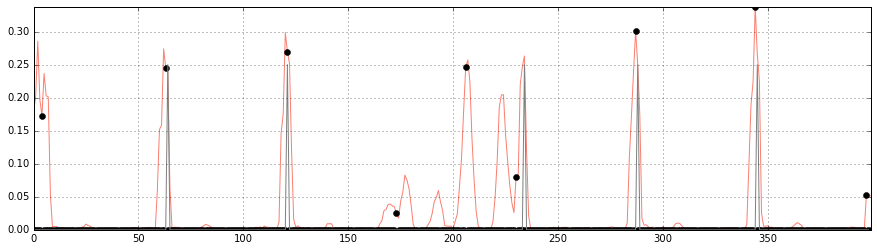

In [76]:
## Fiducial mark - peak detection - integrated signal - original.
peaks_indices = find_peaks_cwt(integrated_signal[:-1], np.arange(10, 15), noise_perc=0.1)

fiducial_mark_idx = np.array([])
fiducial_mark_val_i = np.array([])
fiducial_mark_val_f = np.array([])

for peak_index in peaks_indices:
    fiducial_mark_idx = np.append(fiducial_mark_idx, peak_index)
    fiducial_mark_val_i = np.append(fiducial_mark_val_i, integrated_signal[peak_index])
    fiducial_mark_val_f = np.append(fiducial_mark_val_f, filtered_signal[peak_index-7])
    
fiducial_mark_indication_i = [0] * len(integrated_signal)
for peak_idx, peak_val_i in zip(fiducial_mark_idx, fiducial_mark_val_i):
    fiducial_mark_indication_i[int(peak_idx)] = peak_val_i

plt.figure(figsize=(15,4))
plt.plot(integrated_signal, label="Integrated signal", color="salmon")
plt.plot(fiducial_mark_indication_i, 'ko')
plt.plot(logged_beats / 4, label="Original signal", color="grey")
plt.grid(True)
plt.axis("tight")

# fiducial_mark_indication_f = [0] * len(filtered_signal)
# for peak_idx, peak_val_f in zip(fiducial_mark_idx, fiducial_mark_val_f):
#     fiducial_mark_indication_f[int(peak_idx)] = peak_val_f
# plt.figure(figsize=(15,4))
# plt.plot(filtered_signal, label="Filtered signal", color="salmon")
# plt.plot(fiducial_mark_indication_f, 'ko')
# plt.grid(True)
# plt.axis("tight")

In [77]:
## Thresholding detect peaks - integrated and filtered signal.
for peak_idx, peak_val_i, peak_val_f in zip(fiducial_mark_idx, fiducial_mark_val_i, fiducial_mark_val_f):
    if peak_val_i > threshold_i_1 and peak_val_f > threshold_f_1:
        spk_i = 0.125 * peak_val_i + 0.875 * spk_i
        spk_f = 0.125 * peak_val_f + 0.875 * spk_f
        print "pulse - peak_i: %f, spk_i: %f, threshold_i_1: %f" % (peak_val_i, spk_i, threshold_i_1)
        print "pulse - peak_f: %f, spk_f: %f, threshold_f_1: %f" % (peak_val_f, spk_f, threshold_f_1)
        
        qrs_peak_i = np.append(qrs_peak_f, peak_idx)
        spk_i_vals = np.append(spk_f_vals, spk_f)
        npk_i_vals = np.append(npk_f_vals, npk_f)
        threshold_i_1_vals = np.append(threshold_i_1_vals, threshold_i_1)
        threshold_i_2_vals = np.append(threshold_i_2_vals, threshold_i_2)
        
        qrs_peak_f = np.append(qrs_peak_f, peak_idx)
        spk_f_vals = np.append(spk_f_vals, spk_f)
        npk_f_vals = np.append(npk_f_vals, npk_f)
        threshold_f_1_vals = np.append(threshold_f_1_vals, threshold_f_1)
        threshold_f_2_vals = np.append(threshold_f_2_vals, threshold_f_2)
    else:
        npk_i = 0.125 * peak_val_i + 0.875 * npk_i
        npk_f = 0.125 * peak_val_f + 0.875 * npk_f
        print "noise - peak_i: %f, npk_i: %f, threshold_i_1: %f" % (peak_val_i, npk_i, threshold_i_1)
        print "noise - peak_f: %f, npk_f: %f, threshold_f_1: %f" % (peak_val_f, npk_f, threshold_f_1)
        
        noise_peak_i = np.append(noise_peak_i, peak_idx)
        spk_i_vals = np.append(spk_i_vals, spk_i)
        npk_i_vals = np.append(npk_i_vals, npk_i)
        threshold_i_1_vals = np.append(threshold_i_1_vals, threshold_i_1)
        threshold_i_2_vals = np.append(threshold_i_2_vals, threshold_i_2)
        
        noise_peak_f = np.append(noise_peak_f, peak_idx)
        spk_f_vals = np.append(spk_f_vals, spk_f)
        npk_f_vals = np.append(npk_f_vals, npk_f)
        threshold_f_1_vals = np.append(threshold_f_1_vals, threshold_f_1)
        threshold_f_2_vals = np.append(threshold_f_2_vals, threshold_f_2)
        
    peak_vals_i = np.append(peak_vals_i, peak_val_i)
    peak_vals_f = np.append(peak_vals_f, peak_val_f)
    
    threshold_i_1 = npk_i + 0.25 * (spk_i - npk_i)
    threshold_i_2 = 0.5 * threshold_i_1
    
    threshold_f_1 = npk_f + 0.25 * (spk_f - npk_f)
    threshold_f_2 = 0.5 * threshold_f_1
    

pulse - peak_i: 0.172413, spk_i: 0.021552, threshold_i_1: 0.000000
pulse - peak_f: 1.742816, spk_f: 0.217852, threshold_f_1: 0.000000
pulse - peak_i: 0.244821, spk_i: 0.049460, threshold_i_1: 0.005388
pulse - peak_f: 2.009406, spk_f: 0.441796, threshold_f_1: 0.054463
pulse - peak_i: 0.269674, spk_i: 0.076987, threshold_i_1: 0.012365
pulse - peak_f: 1.615745, spk_f: 0.588540, threshold_f_1: 0.110449
pulse - peak_i: 0.024744, spk_i: 0.070457, threshold_i_1: 0.019247
pulse - peak_f: 1.670878, spk_f: 0.723832, threshold_f_1: 0.147135
pulse - peak_i: 0.245924, spk_i: 0.092390, threshold_i_1: 0.017614
pulse - peak_f: 1.432042, spk_f: 0.812358, threshold_f_1: 0.180958
pulse - peak_i: 0.079798, spk_i: 0.090816, threshold_i_1: 0.023098
pulse - peak_f: 3.476250, spk_f: 1.145345, threshold_f_1: 0.203090
pulse - peak_i: 0.301320, spk_i: 0.117129, threshold_i_1: 0.022704
pulse - peak_f: 1.597593, spk_f: 1.201876, threshold_f_1: 0.286336
pulse - peak_i: 0.337814, spk_i: 0.144715, threshold_i_1: 0.02

(0.0, 8.0, 0.0, 3.4762502959607069)

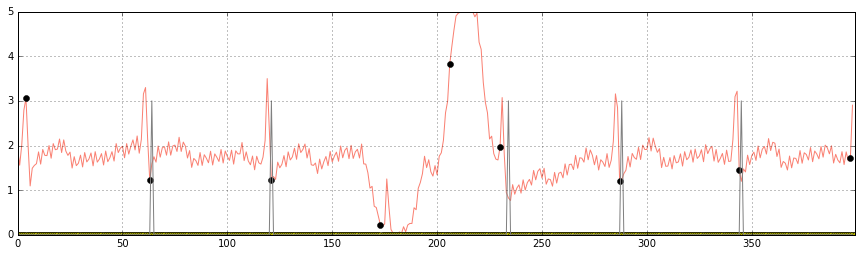

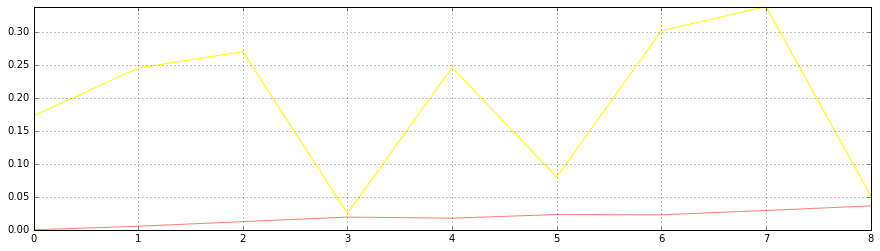

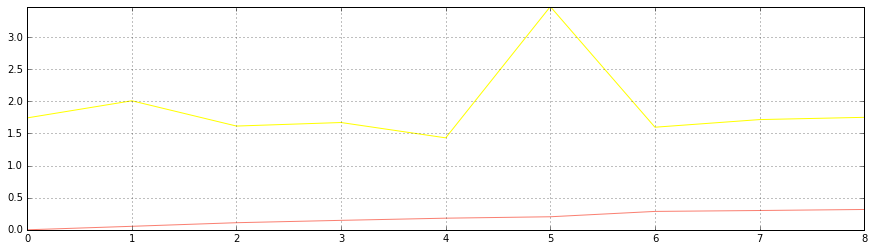

In [78]:
## Plotting detected peaks - integrated signal.
qrs_peak_indication_i = [0] * len(integrated_signal)
for peak_i in qrs_peak_i:
    qrs_peak_indication_i[int(peak_i)] = raw_signal[int(peak_i)]

noise_peak_indication_i = [0] * len(integrated_signal)
for peak_i in noise_peak_i:
    noise_peak_indication_i[int(peak_i)] = raw_signal[int(peak_i)]
   
plt.figure(figsize=(15,4))
plt.plot(raw_signal, label="Integrated signal", color="salmon")
plt.plot(qrs_peak_indication_i, 'ko')
plt.plot(noise_peak_indication_i, 'yo')
plt.plot(logged_beats * 3, label="Original signal", color="grey")
plt.grid(True)
plt.axis("tight")

plt.figure(figsize=(15,4))
plt.plot(threshold_i_1_vals, color="salmon", label='Threshold i_1')
plt.plot(peak_vals_i, color="yellow", label='Peak')
plt.grid(True)
plt.axis('tight')

plt.figure(figsize=(15,4))
plt.plot(threshold_f_1_vals, color="salmon", label='Threshold f_1')
plt.plot(peak_vals_f, color="yellow", label='Peak')
plt.grid(True)
plt.axis('tight')

(0.0, 399.0, 0.0, 5.0)

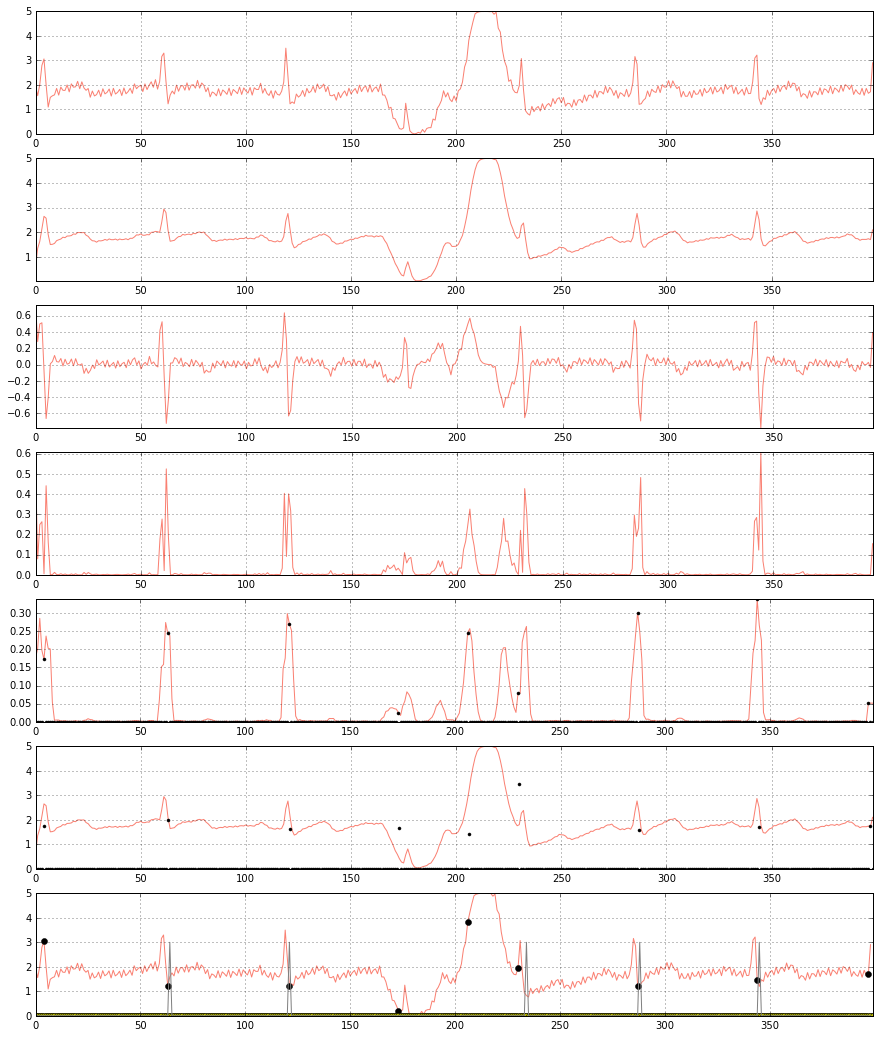

In [79]:
## Plot everything.
plt.figure(figsize=(15,18))
plt.subplot(711)
plt.plot(raw_signal, label="Original signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(712)
plt.plot(filtered_signal, label="Filtered signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(713)
plt.plot(differentiated_signal, label="Differentiated signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(714)
plt.plot(squared_signal, label="Squared signal", color="salmon")
plt.grid(True)
plt.axis("tight")

fiducial_mark_indication_i = [0] * len(integrated_signal)
for peak_idx_i, peak_val_i in zip(fiducial_mark_idx, fiducial_mark_val_i):
    fiducial_mark_indication_i[int(peak_idx_i)] = peak_val_i
plt.subplot(715)
plt.plot(integrated_signal, label="Integrated signal", color="salmon")
plt.plot(fiducial_mark_indication_i, 'k.')
plt.grid(True)
plt.axis("tight")

fiducial_mark_indication_f = [0] * len(filtered_signal)
for peak_idx, peak_val_f in zip(fiducial_mark_idx, fiducial_mark_val_f):
    fiducial_mark_indication_f[int(peak_idx)] = peak_val_f
plt.subplot(716)
plt.plot(filtered_signal, label="Filtered signal", color="salmon")
plt.plot(fiducial_mark_indication_f, 'k.')
plt.grid(True)
plt.axis("tight")

qrs_peak_indication_i = [0] * len(integrated_signal)
for peak_i in qrs_peak_i:
    qrs_peak_indication_i[int(peak_i)] = raw_signal[int(peak_i)]
noise_peak_indication_i = [0] * len(integrated_signal)
for peak_i in noise_peak_i:
    noise_peak_indication_i[int(peak_i)] = raw_signal[int(peak_i)]
plt.subplot(717)
plt.plot(raw_signal, label="Integrated signal", color="salmon")
plt.plot(qrs_peak_indication_i, 'ko')
plt.plot(noise_peak_indication_i, 'yo')
plt.plot(logged_beats * 3, label="Original signal", color="grey")
plt.grid(True)
plt.axis("tight")
